## Massachusetts General Hospital

### Overview
You are provided with synthetic data of approximately 1,000 patients from Massachusetts General Hospital, covering the years 2011 to 2022. The dataset includes information on patient demographics, insurance coverage, medical encounters, and procedures.

The link to the dataset is [here](https://maven-datasets.s3.amazonaws.com/Hospital+Patient+Records/Hospital+Patient+Records.zip).

Business problem: Given encounter data and patient data, predict the total claim cost.

Potential business use cases:
* Predicted total claim costs can be used as a quote at triage.
* Predictions can be sent ahead to insurance provider for pre-authorization or a more informal check if the patient still has credits.
* Total claim costs that are not comparable to predicted total claim cost can be audited by the insurance provider for potential cases of overutilization or unnecessary care leading to overbilling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
procedures = pd.read_csv('./data/procedures.csv').rename(columns=lambda x: x.lower())
encounters = pd.read_csv('./data/encounters.csv').rename(columns=lambda x: x.lower())
patients = pd.read_csv('./data/patients.csv').rename(columns=lambda x: x.lower())
organizations = pd.read_csv('./data/organizations.csv').rename(columns=lambda x: x.lower())
payers = pd.read_csv('./data/payers.csv').rename(columns=lambda x: x.lower())

procedures.shape, encounters.shape, patients.shape, organizations.shape, payers.shape

((47701, 9), (27891, 14), (974, 20), (1, 8), (10, 7))

## Entity relationship diagram of the data provided

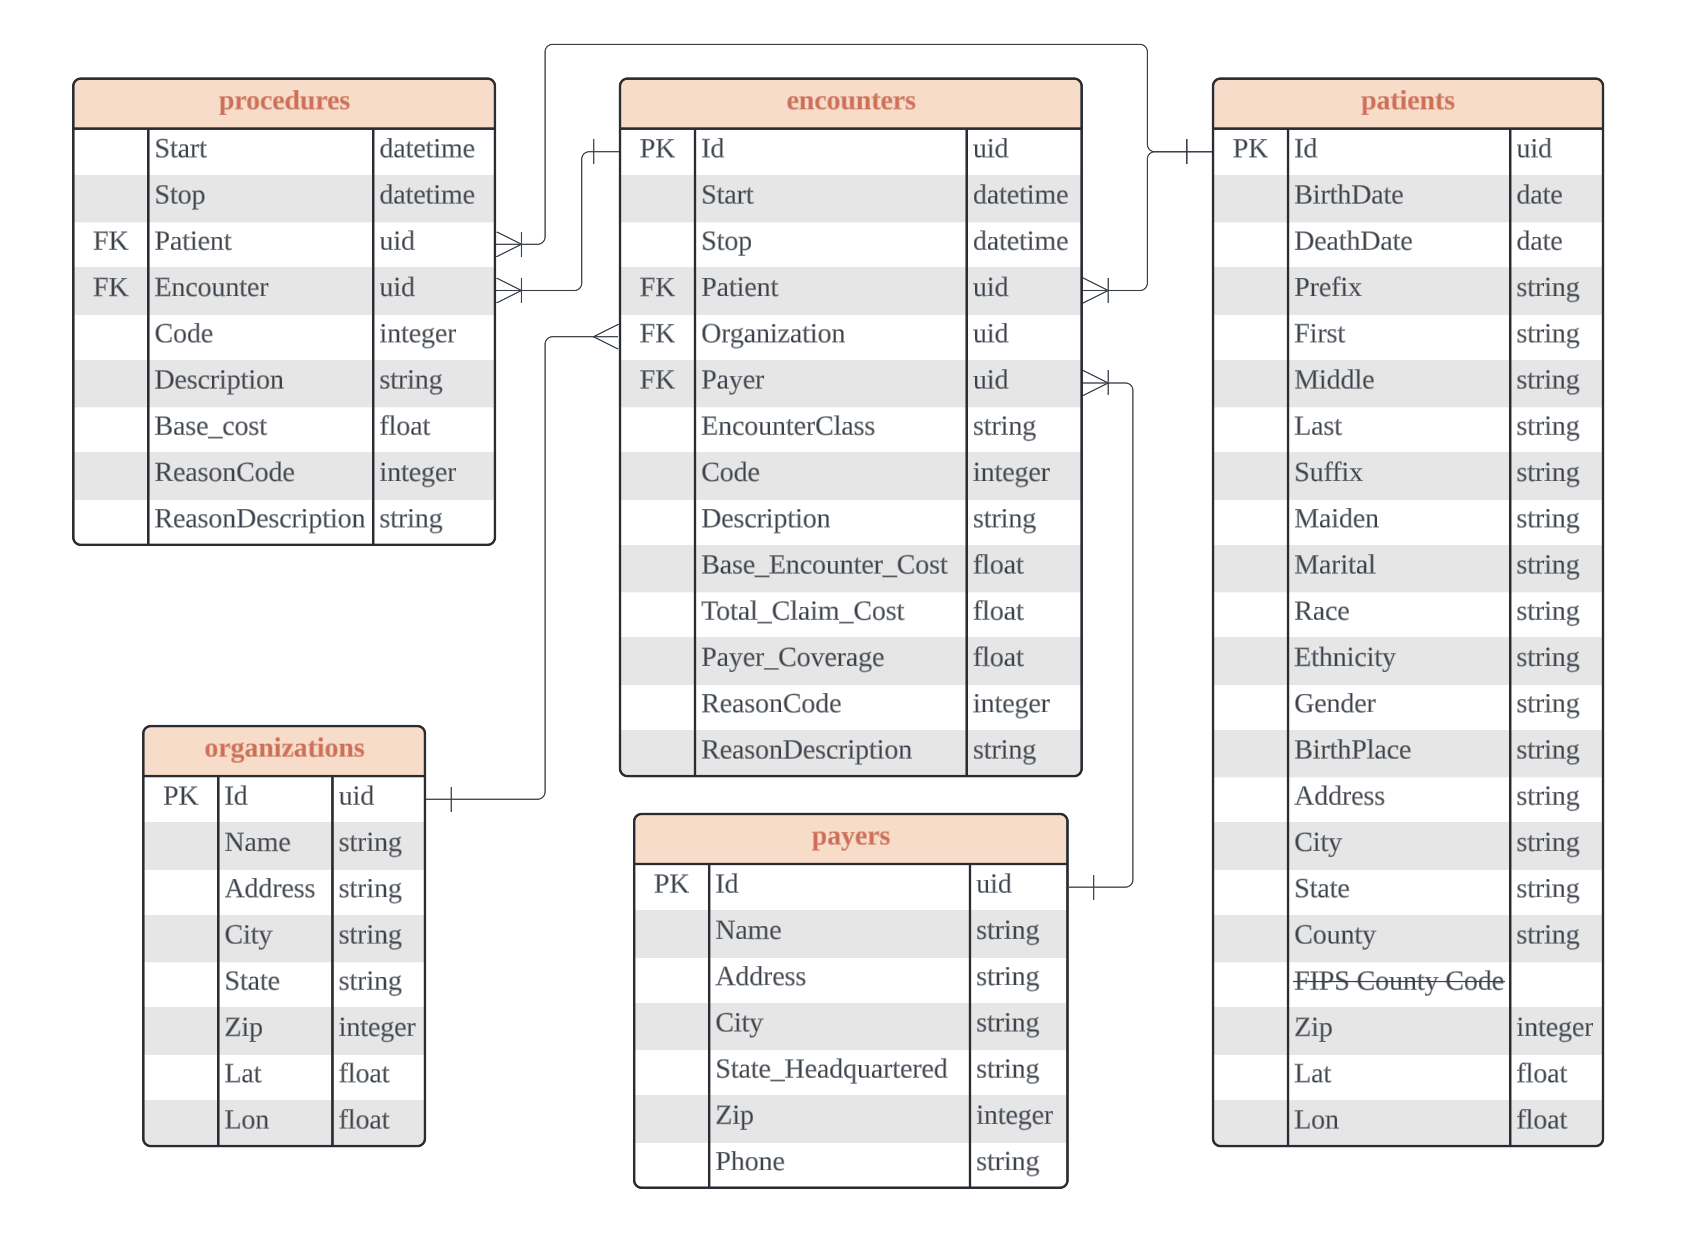

### Some observations on data quality and context:
* There is only one organization/hospital as what is expected from the overview. Patients are also from the same state. These data would not be relevant and thus will not be considered as we move forward.
* There are missing reason code and reason descriptions in both procedure and encounter tables. As these are diagnosis codes from the same encounter, data from these two tables can supplement each other.
* Procedures table has records with the same patient id and encounter id but have different dates. The different dates of procedures are not indicated in the Encounters table. These are usually procedures done on multiple sessions i.e. therapy but are billed only once in the encounters table.
* The total claim cost is approximately the total base cost of all procedures + base encounter cost. The difference from the total of the base costs are not calculated in straightforward manner.
* A single procedure code can have multiple base costs.
* Not all encounters have procedures (not all encounter ids are in procedures table).

## Preprocessing
### check and remove duplicates

No duplicates for all tables and all primary keys are unique. Procedures tables, however, does not have a primary key but all rows are unique.

In [3]:
def check_duplicates(dataframe, primary_key_column):
    if (dataframe.shape == dataframe.drop_duplicates().shape) & (len(dataframe) == dataframe[primary_key_column].nunique()):
        return 'table has no duplicates'
    else:
        return 'Table has duplicates. Table shape: {}. Dropped duplicates: {}. Unique ids: {}'.format(dataframe.shape, dataframe.drop_duplicates().shape, dataframe[primary_key_column].nunique())

In [4]:
print('patients', check_duplicates(patients, 'id'))
print('payers', check_duplicates(payers, 'id'))
print('organizations', check_duplicates(organizations, 'id'))
print('encounters', check_duplicates(encounters, 'id'))

patients table has no duplicates
payers table has no duplicates
organizations table has no duplicates
encounters table has no duplicates


The procedures table does not have a primary key or unique id. It only has the patient id and encounter id. We'll treat this differently.

From the stats below, the columns with the patient id, encounter id, start timestamp of the encounter, and procedure code/description is enough to differentiate each record.

In [5]:
column_subset_a = ['patient', 'encounter', 'code']
column_subset_b = ['patient', 'encounter', 'start', 'code']
procedures.shape, procedures.drop_duplicates().shape, procedures[column_subset_a].drop_duplicates().shape, procedures[column_subset_b].drop_duplicates().shape

((47701, 9), (47701, 9), (43378, 3), (47701, 4))

### check missing values

In [6]:
def check_missing_data(df):
    missing_check = (df.isnull()) | (df == '')
    if len(df[missing_check.any(axis=1)]) > 0:
        return df[missing_check.any(axis=1)]
    else:
        return 'table has no missing data'

In [7]:
print('organizations', check_missing_data(organizations))
print('payers table\n')
check_missing_data(payers)

organizations table has no missing data
payers table



,id,name,address,city,state_headquartered,zip,phone
9,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,NO_INSURANCE,NaN,NaN,NaN,NaN,NaN


The organizations table only has one record and the payers table has nulls on the record that signifies the absence of insurance. There is no need to impute data for this.

For the tables encounters and procedures, missing data is only at the reason code and reason description columns. Treatment of the missing data for this will be shown in the next steps.

In [8]:
print('Encounters table has {} records.'.format(len(encounters)))
print('The columns reasoncode and reasondescription has {} rows with missing data.'.format(len(check_missing_data(encounters[['reasoncode', 'reasondescription']]))))
print('Excluding reason code and reason description columns, encounters', check_missing_data(encounters[[col for col in encounters.columns if col not in ['reasoncode', 'reasondescription']]]))

Encounters table has 27891 records.
The columns reasoncode and reasondescription has 19541 rows with missing data.
Excluding reason code and reason description columns, encounters table has no missing data


In [9]:
print('Procedures table has {} records.'.format(len(procedures)))
print('The columns reasoncode and reasondescription has {} rows with missing data.'.format(len(check_missing_data(procedures[['reasoncode', 'reasondescription']]))))
print('Excluding reason code and reason description columns, procedures', check_missing_data(procedures[[col for col in procedures.columns if col not in ['reasoncode', 'reasondescription']]]))

Procedures table has 47701 records.
The columns reasoncode and reasondescription has 36945 rows with missing data.
Excluding reason code and reason description columns, procedures table has no missing data


In the patients table, we will exlude PII columns, except for the birthdate which we will have to convert to age later. Death date will also be excluded since it is likely to not be relevant in the scope and missing data shall not be imputed. We should also be careful around building a model containing race, ethnicity, and gender due to legal and ethical considerations when we do some inferences. We can exclude these later on once we prove that this has little to no significance on the behavior of the data during EDA.

In [10]:
print('patients table initial columns:', patients.columns.values.tolist())
# Exclude marital too? Currently no support for divorce (D) or widowing (W)
patients_exclude_columns = ['prefix', 'first', 'last', 'suffix', 'maiden', 'birthplace', 'address', 'city', 'state', 'county', 'zip']
patients = patients.drop(columns=patients_exclude_columns)
check_missing_data(patients)

patients table initial columns: ['id', 'birthdate', 'deathdate', 'prefix', 'first', 'last', 'suffix', 'maiden', 'marital', 'race', 'ethnicity', 'gender', 'birthplace', 'address', 'city', 'state', 'county', 'zip', 'lat', 'lon']


,id,birthdate,deathdate,marital,race,ethnicity,gender,lat,lon
0,5605b66b-e92d-c16c-1b83-b8bf7040d51f,1977-03-19,NaN,M,white,nonhispanic,F,42.290937,-70.975503
1,6e5ae27c-8038-7988-e2c0-25a103f01bfa,1940-02-19,NaN,M,white,nonhispanic,M,42.308831,-71.063162
2,8123d076-0886-9007-e956-d5864aa121a7,1958-06-04,NaN,M,white,nonhispanic,M,42.265177,-70.967085
5,8e9650d1-788a-78f9-4a28-d08f7f95354a,1928-12-25,NaN,M,white,hispanic,M,42.371026,-71.118107
6,183df435-4190-060e-8f8e-bf63c572b266,1957-11-08,NaN,M,asian,nonhispanic,F,42.358928,-71.156224
7,720560d4-51da-c38c-ee90-c15935278df1,1972-06-27,NaN,M,white,nonhispanic,M,42.297904,-71.015983
8,217851b0-5f47-d376-18b9-0fe4ba77207e,1954-03-06,NaN,S,black,hispanic,M,42.384084,-71.100689
9,ff331e5c-ab16-e218-f39a-63e11de1ed75,1927-07-10,NaN,M,native,hispanic,M,42.358519,-71.078598
10,affa7bf1-f4fc-d3f7-747c-db8f32d105cf,1933-05-08,NaN,M,white,nonhispanic,M,42.320186,-71.145693
11,becb15c3-a135-8fb2-ea09-583043922a3a,1948-05-30,NaN,M,white,nonhispanic,F,42.348327,-71.096466


### Impute Missing Values, Conversion of Data Types, and Building feature matrix
Since missing values are only from REASON CODE and REASON DESCRIPTION in both encounters and procedures table. Let's try combining the two tables since since these are both based on diagnosis codes from SNOMED-CT.

### Feature engineering
* number of minutes per procedure
* total claim cost - base encounter cost + sum of procedures (except for some procedures like therapy)
* page of patient at time of encounter

In [11]:
from pycaret.regression import *
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
pd.set_option('display.max_rows', None)

In [12]:
import sqlite3
conn = sqlite3.connect('mgh_data.db')

procedures.to_sql('procedures', conn, if_exists='replace', index=False)
encounters.to_sql('encounters', conn, if_exists='replace', index=False)
patients.to_sql('patients', conn, if_exists='replace', index=False)
organizations.to_sql('organizations', conn, if_exists='replace', index=False)
payers.to_sql('payers', conn, if_exists='replace', index=False)
# clear out the variables - laptop is lagging
del procedures; del encounters; del patients; del organizations; del payers;

In [134]:
query = """
select
e.id as encounter_id
, e.patient as patient_id
, (cast(strftime('%Y', start) as integer) - cast(strftime('%Y', birthdate) as integer)) - 
    case when strftime('%m-%d', start) < strftime('%m-%d', birthdate) then 1 else 0 end as age_on_encounter
, cast((strftime('%s', stop) - strftime('%s', start)) / 60 as integer) as encounter_duration_min
, gender                 -- M or F (GDPR SENSITIVE)
, ethnicity              -- hispanic or nonhispanic (GDPR SENSITIVE)
, race                   -- white, asian, black, native, hawaiian, other (GDPR SENSITIVE)
, round(6371 * 2 * asin(sqrt(power(sin((radians(42.3625) - radians(lat)) / 2), 2) + 
        cos(radians(42.3625)) * cos(radians(lat)) * power(sin((radians(-71.0696) - radians(lon)) / 2), 2))), 2) AS distance_km
, py.name as payer_name
, case when payer='b1c428d6-4f07-31e0-90f0-68ffa6ff8c76' then 0 else 1 end as with_insurance
, encounterclass
, cast(e.code as text) as ecode
, base_encounter_cost
, total_claim_cost
from encounters e
left join patients pt on e.patient = pt.id
left join payers py on py.id = e.payer
"""
encounters = pd.read_sql_query(query, conn)
categorical_cols = encounters.select_dtypes(include=['object']).columns.tolist()[2:]
print('expected shape: ({},{})'.format(len(encounters[['encounter_id', 'patient_id']].drop_duplicates()), 
                                       sum([encounters[col].nunique() for col in categorical_cols])-2 + len(encounters.columns.tolist())-len(categorical_cols)))
print('expected feature sum:', len(encounters[encounters.gender=='M']) + len(encounters[encounters.ethnicity=='nonhispanic']) + sum([encounters[col].value_counts().sum() for col in categorical_cols[2:]]))
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
onehot_encoded = encoder.fit_transform(encounters[categorical_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
encounters = pd.concat([encounters, onehot_df], axis=1)
encounters = encounters.drop(categorical_cols, axis=1)
print('output shape:', encounters.shape)
print('output feature sum:', encounters[encoder.get_feature_names_out(categorical_cols)].sum().sum())
encounters.head()

expected shape: (27891,77)
expected feature sum: 147792
output shape: (27891, 77)
output feature sum: 147792.0


,encounter_id,patient_id,age_on_encounter,encounter_duration_min,distance_km,with_insurance,base_encounter_cost,total_claim_cost,gender_M,ethnicity_nonhispanic,...,ecode_424619006,ecode_439740005,ecode_448337001,ecode_47505003,ecode_50849002,ecode_56876005,ecode_698314001,ecode_702927004,ecode_79094001,ecode_86013001
0,32c84703-2481-49cd-d571-3899d5820253,3de74169-7f67-9304-91d4-757e0f3a14d2,82,212,2.66,0,85.55,1018.02,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c98059da-320a-c0a6-fced-c8815f3e3f39,d9ec2e44-32e9-9148-179a-1653348cc4e2,46,17,2.75,0,142.58,2619.36,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4ad28a3a-2479-782b-f29c-d5b3f41a001e,73babadf-5b2b-fee7-189e-6f41ff213e01,86,15,6.69,1,85.55,461.59,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c3f4da61-e4b4-21d5-587a-fbc89943bc19,3b46a0b7-0f34-9b9a-c319-ace4a1f58c0b,87,15,4.65,0,136.80,1784.24,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a9183b4f-2572-72ea-54c2-b3cd038b4be7,fa006887-d93c-d302-8b89-f3c25f88c0e1,58,15,13.91,1,85.55,234.72,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
query = """
select distinct 
id as encounter_id
, patient as patient_id
, cast(cast(reasoncode as integer) as text) as rsn
from encounters
where reasoncode is not null

union all

select distinct 
encounter as encounter_id
, patient as patient_id
, cast(cast(reasoncode as integer) as text) as rsn
from procedures
where reasoncode is not null
"""
reasondesc = pd.read_sql_query(query, conn).drop_duplicates()
conn.close()
print('expected shape: ({},{})'.format(len(reasondesc[['encounter_id', 'patient_id']].drop_duplicates()), reasondesc.rsn.nunique()+2))
print('expected feature sum:', len(reasondesc))
reasondesc = reasondesc.groupby(['encounter_id', 'patient_id'])['rsn'].apply(list).reset_index(name='rsn')
mlb = MultiLabelBinarizer()
encoded_data = mlb.fit_transform(reasondesc['rsn'])
feature_names = [f'rsn_{rsncode}' for rsncode in mlb.classes_]
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
reasondesc = pd.concat([reasondesc.drop(columns=['rsn']), encoded_df], axis=1)
print('output shape:', reasondesc.shape)
print('output feature sum:', reasondesc[reasondesc.columns.tolist()[2:]].sum().sum())
reasondesc.head()

expected shape: (11299,89)
expected feature sum: 11396
output shape: (11299, 89)
output feature sum: 11396


,encounter_id,patient_id,rsn_10509002,rsn_109838007,rsn_124171000119105,rsn_126906006,rsn_156073000,rsn_15724005,rsn_16114001,rsn_162573006,...,rsn_83664006,rsn_840539006,rsn_840544004,rsn_87433001,rsn_88805009,rsn_90560007,rsn_91302008,rsn_93761005,rsn_94260004,rsn_95417003
0,00092210-7294-428e-1334-9d3f4b671ca4,41a6be0c-6388-3b28-daff-dc60e5d6d61b,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0011d269-53cb-06c9-e0df-10f3d01d8c47,dbc49a8f-0f3d-e9a3-0698-d0ef0a07a31e,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00169f6a-632c-357a-3cb2-a91a71c48f11,bb9e2b36-bb5f-eda2-f1ae-f2c74a225272,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00240922-2219-9d5d-e727-0767db3c2f13,5427845a-82ab-b6c9-e70b-aeb672ddd5d7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00262cfb-5257-81ea-70e3-f176d9186ef5,4ccb1d0f-6861-58a2-dde4-983716f6349b,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
print('main table', check_missing_data(main))
print('reasondesc table', check_missing_data(reasondesc))
main = encounters.merge(reasondesc, on=['encounter_id', 'patient_id'], how='left').fillna(0)
print('main table', check_missing_data(main))
print(main.shape)
main.head()

main table table has no missing data
reasondesc table table has no missing data
main table table has no missing data
(27891, 164)


,encounter_id,patient_id,age_on_encounter,encounter_duration_min,distance_km,with_insurance,base_encounter_cost,total_claim_cost,gender_M,ethnicity_nonhispanic,...,rsn_83664006,rsn_840539006,rsn_840544004,rsn_87433001,rsn_88805009,rsn_90560007,rsn_91302008,rsn_93761005,rsn_94260004,rsn_95417003
0,32c84703-2481-49cd-d571-3899d5820253,3de74169-7f67-9304-91d4-757e0f3a14d2,82,212,2.66,0,85.55,1018.02,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,c98059da-320a-c0a6-fced-c8815f3e3f39,d9ec2e44-32e9-9148-179a-1653348cc4e2,46,17,2.75,0,142.58,2619.36,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4ad28a3a-2479-782b-f29c-d5b3f41a001e,73babadf-5b2b-fee7-189e-6f41ff213e01,86,15,6.69,1,85.55,461.59,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c3f4da61-e4b4-21d5-587a-fbc89943bc19,3b46a0b7-0f34-9b9a-c319-ace4a1f58c0b,87,15,4.65,0,136.80,1784.24,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a9183b4f-2572-72ea-54c2-b3cd038b4be7,fa006887-d93c-d302-8b89-f3c25f88c0e1,58,15,13.91,1,85.55,234.72,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Examine and remove outliers

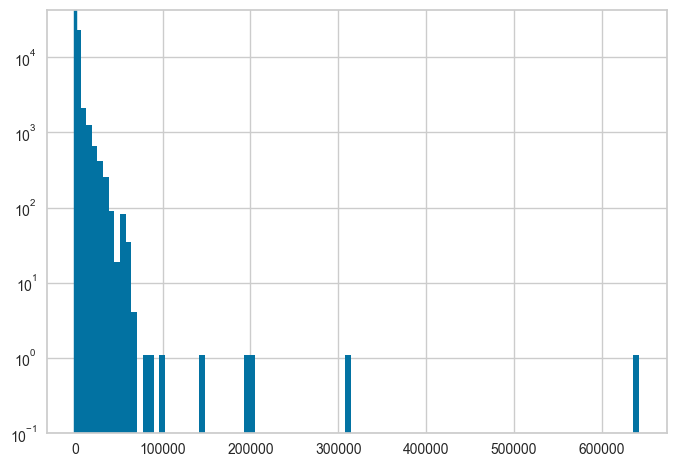

In [61]:
fig, ax = plt.subplots()
main.total_claim_cost.hist(ax=ax, bins=100, bottom=0.1)
plt.axvline(quartiles[0.75])
plt.axvline(quartiles[0.25])
ax.set_yscale('log'); 

In [216]:
from sklearn.neighbors import LocalOutlierFactor
data = main.total_claim_cost
data_reshaped = main.total_claim_cost.values.reshape(-1, 1)
lof = LocalOutlierFactor(n_neighbors=2)
outliers = lof.fit_predict(data_reshaped)
outlier_mask = outliers == -1
filtered_data = main.total_claim_cost[~outlier_mask]
print('removed {} rows of outliers.'.format(len(main.total_claim_cost)-len(filtered_data)))

removed 2564 rows of outliers.


The local outlier factor method was chosen to remove most of the outliers because the target variable's distribution is clearly skewed.

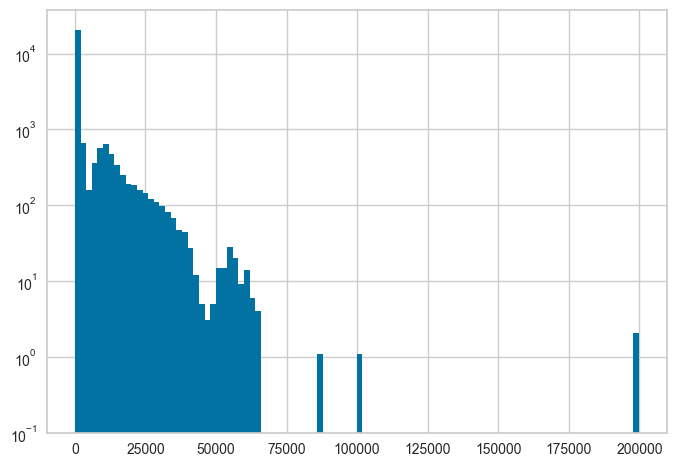

In [217]:
fig, ax = plt.subplots()
filtered_data.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log'); 

And while the LOF removed most of the outliers, let's remove the other three data points shown above that still look like outliers, setting the outlier threshold at 75000 on the total claim cost. This results to a more continuous distribution on the total claim cost as shown below.

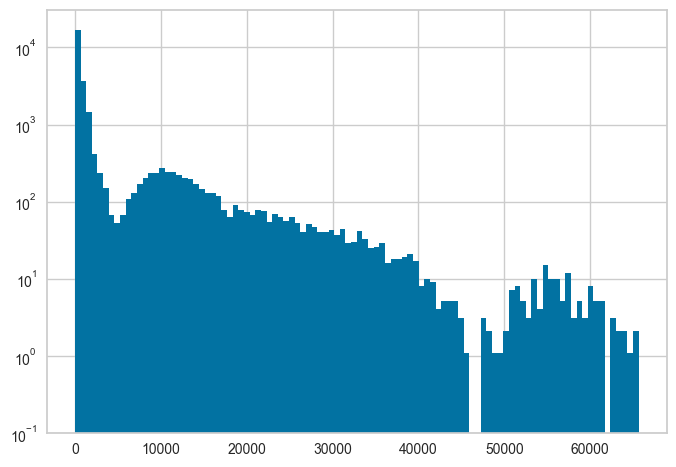

In [73]:
fig, ax = plt.subplots()
main[main.total_claim_cost<75000].total_claim_cost.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log');

## Model training, comparisons, and evaluation

In [108]:
reg = setup(main[main.total_claim_cost<75000][main.columns.values.tolist()[2:]], 
            target='total_claim_cost', 
            session_id=123, 
            train_size=0.8,
            normalize=True, 
            transformation=True, 
            # data_split_stratify=True,
            verbose=True)

,Description,Value
0,Session id,123
1,Target,total_claim_cost
2,Target type,Regression
3,Original data shape,"(27883, 162)"
4,Transformed data shape,"(27883, 162)"
5,Transformed train set shape,"(22306, 162)"
6,Transformed test set shape,"(5577, 162)"
7,Numeric features,161
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1215.7008,12890776.9815,3588.8157,0.7976,0.5863,0.5604,4.5020
lasso,Lasso Regression,1730.8725,14015311.8809,3742.0585,0.7802,1.3089,2.8196,1.8940
ridge,Ridge Regression,1731.6189,14016191.8607,3742.1783,0.7801,1.3195,2.8308,0.7160
br,Bayesian Ridge,1732.1609,14016360.8265,3742.2048,0.7801,1.3120,2.8268,0.8610
gbr,Gradient Boosting Regressor,1747.8950,14077142.1240,3750.6551,0.7792,1.3873,2.9618,1.6870


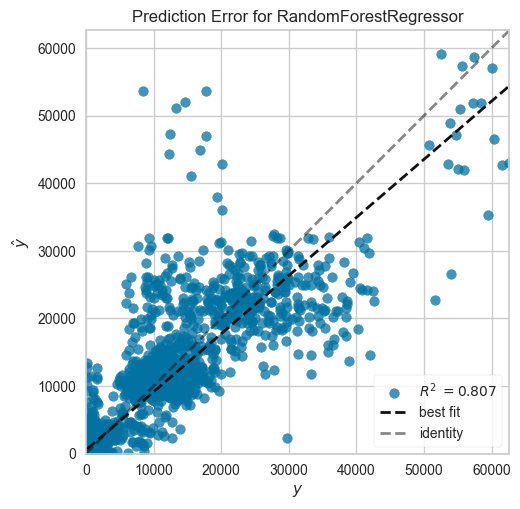

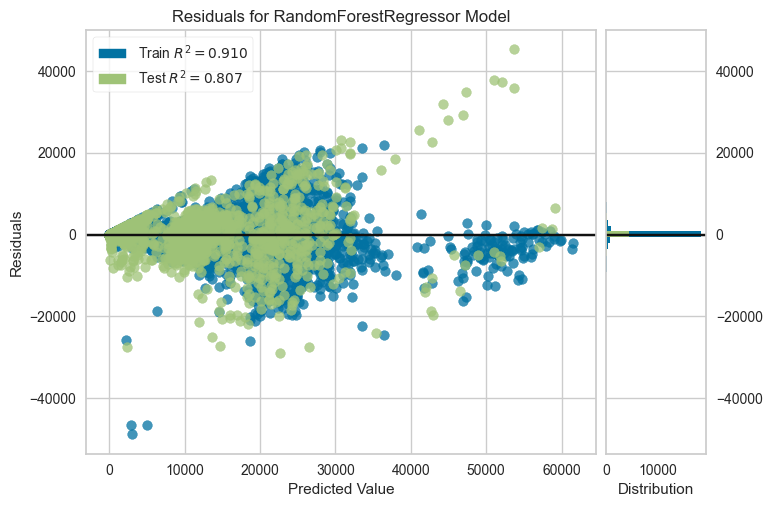

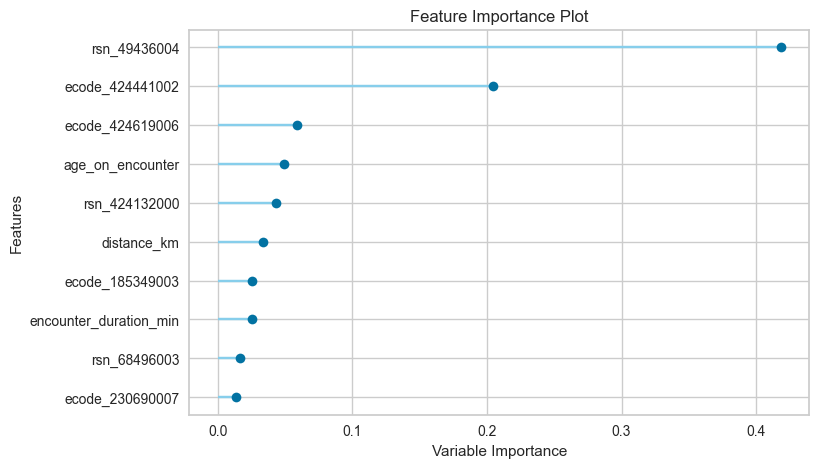

In [109]:
best = compare_models(include=['gbr', 'rf', 'ridge', 'lasso', 'br'])
plot = plot_model(best, plot = 'error')
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

From the comparison of the models above, Random forest regressor is the best pick that perfoms well on all of the metrics used. The low MAE and MAPE indicates that the model predicts values closer to the actual values on average and makes it less sensitive to outliers. Low MSE and RMSE also indicate that the model performs best in minimizing larger errors compared to the other models. Random forest can also handle lower feature-to-sample ratio which can work well if there are new features added on the reason codes and encounter codes. The model can also potentially capture non-linear relationships between features and the target variable without requiring normally distributed features, this is especially crucial given that the dataset does not follow normal distribution in numerical features. The only caveat in picking this is the training time, where it is significantly takes longer to train than the rest of the models.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1277.6320,13174813.2824,3629.7126,0.7837,0.7642,0.8439
1,1271.0506,12972592.1078,3601.7485,0.8094,0.6860,0.8219
2,1298.2154,12356062.9310,3515.1192,0.8036,0.7219,0.9230
3,1277.8361,11168247.7097,3341.8928,0.8223,0.7519,0.9066
4,1322.2905,14032039.2419,3745.9364,0.7808,0.7098,0.7320
5,1161.3499,12227045.4857,3496.7192,0.7872,0.6304,0.6489
6,1248.1169,12561079.3943,3544.1613,0.8106,0.7838,0.8912
7,1186.1679,12499855.8216,3535.5135,0.8004,0.8060,0.7306
8,1193.7002,12005722.2940,3464.9275,0.8133,0.7812,0.9338


Fitting 10 folds for each of 10 candidates, totalling 100 fits


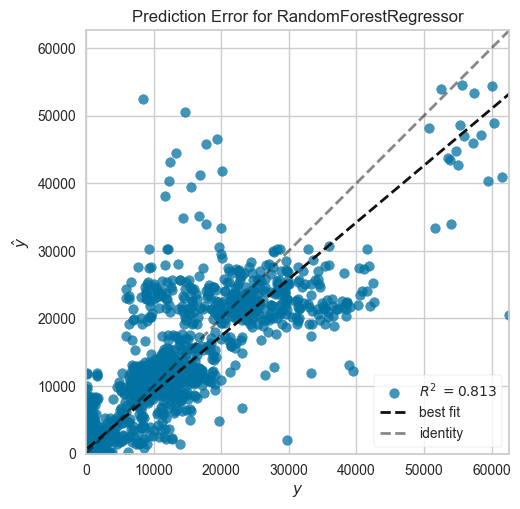

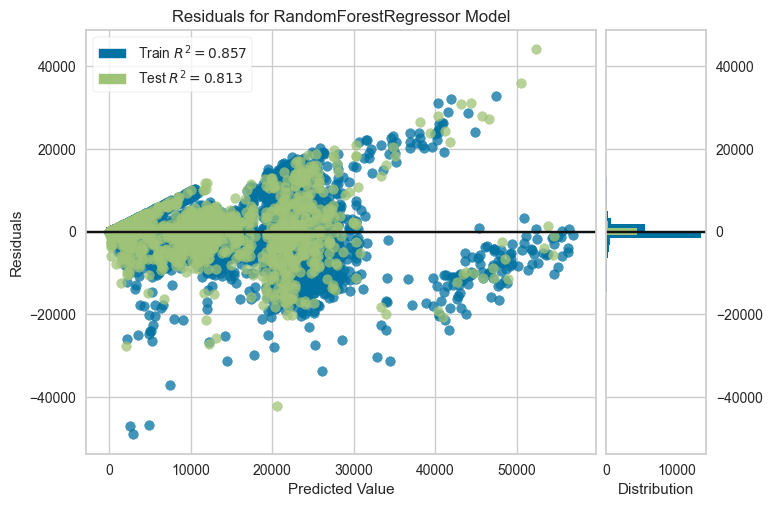

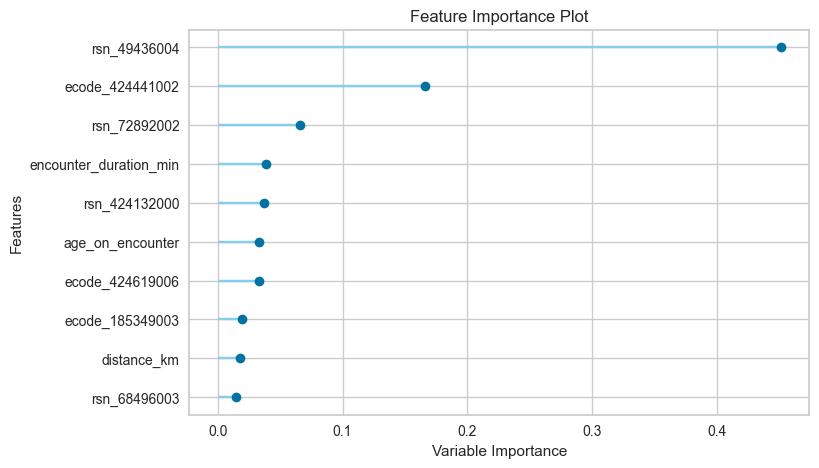

In [110]:
custom_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.7, 1.0]
}
tuned_best = tune_model(best, n_iter=10, custom_grid=custom_grid)
plot = plot_model(tuned_best, plot = 'error')
plot_model(tuned_best, plot = 'residuals')
plot_model(tuned_best, plot = 'feature')

In [111]:
final_model = finalize_model(tuned_best)
save_model(tuned_best, 'best_model')
# best = load_model('final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age_on_encounter',
                                              'encounter_duration_min',
                                              'distance_km', 'with_insurance',
                                              'base_encounter_cost', 'gender_M',
                                              'ethnicity_nonhispanic',
                                              'race_asian', 'race_black',
                                              'race_hawaiian', 'race_native',
                                              'race_other', 'race_white',
                                              'payer_name_Aetna',
                                              'payer_name_Anthem',
                                              'pa...
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                

This indicates that the tuned model explains 85.7% of the variance in the training data. This is relatively a high train score and suggests that the model has captured most of the underlying patterns in the training set. And in the test data, the model explains 81.3% of the variance in the test data. This score is slightly lower than the train score, which is expected because the test data is unseen by the model during training. The R-squared values on both the train and test data shows a good generalization of the dataset in predicting the total claim cost.

### Removing normalization and transformation
Since the chosen model is known to handle different scales and distributions well because they make binary splits based on feature values. This means they are not as affected by the distribution or scale of the features. In the example below, we can see that the resulting R-squared values from the model, 0.855 from training set and 0.815 from the testing set, are not far from the demonstrated performance of the best model that was shown above. This confirms the robustness of Random Forest regressors to data sets with sparse categorical features and numerical feature that do not follow normal distribution. And for practical considerations, it can be said that normalization and transformation on the data set are not crucial on the prediction.

,Description,Value
0,Session id,789
1,Target,total_claim_cost
2,Target type,Regression
3,Original data shape,"(27883, 154)"
4,Transformed data shape,"(27883, 154)"
5,Transformed train set shape,"(22306, 154)"
6,Transformed test set shape,"(5577, 154)"
7,Numeric features,153
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1178.3973,11727307.6717,3424.5157,0.8210,0.5959,0.5799
1,1190.0791,12225490.3740,3496.4969,0.8114,0.5762,0.6236
2,1146.1565,12521654.2086,3538.5949,0.7956,0.5270,0.4498
3,1281.0679,12585592.6576,3547.6179,0.8133,0.5897,0.5466
4,1229.6097,13206700.4010,3634.1024,0.7893,0.6725,0.8410
5,1134.0013,11406909.5229,3377.4117,0.8170,0.5537,0.5081
6,1163.2670,11764973.3145,3430.0107,0.8116,0.6207,0.5787
7,1185.0203,13917288.7652,3730.5883,0.7427,0.6271,0.5584
8,1306.7932,16675013.3893,4083.5050,0.7492,0.5623,0.5172


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1191.2244,11269278.3176,3356.9746,0.8280,0.6642,0.6651
1,1208.9291,12040784.3688,3469.9833,0.8143,0.6438,0.7127
2,1170.8097,11631517.9212,3410.5011,0.8101,0.6174,0.5692
3,1268.1577,11859057.5538,3443.6982,0.8241,0.6573,0.6299
4,1212.7945,12410503.2922,3522.8544,0.8020,0.7151,0.9187
5,1136.2667,10683430.3789,3268.5517,0.8286,0.6139,0.6671
6,1186.8725,11636286.7651,3411.2002,0.8137,0.7109,0.7389
7,1226.5498,13606818.2602,3688.7421,0.7484,0.7409,0.6998
8,1315.7666,15862095.7260,3982.7247,0.7615,0.6312,0.6175


Fitting 10 folds for each of 10 candidates, totalling 100 fits


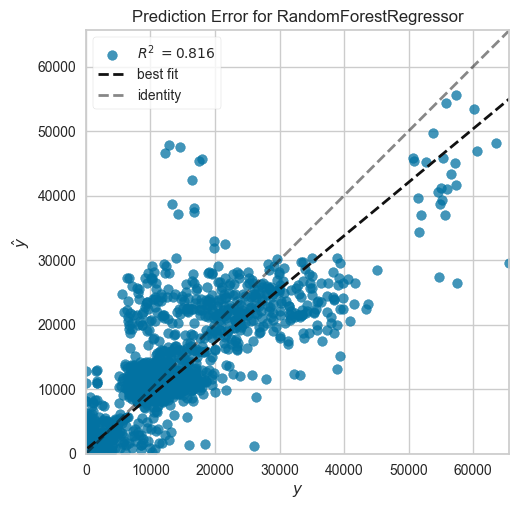

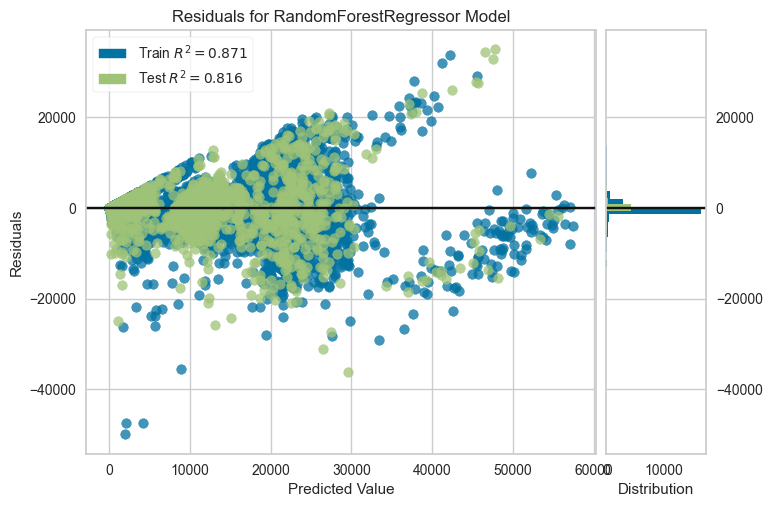

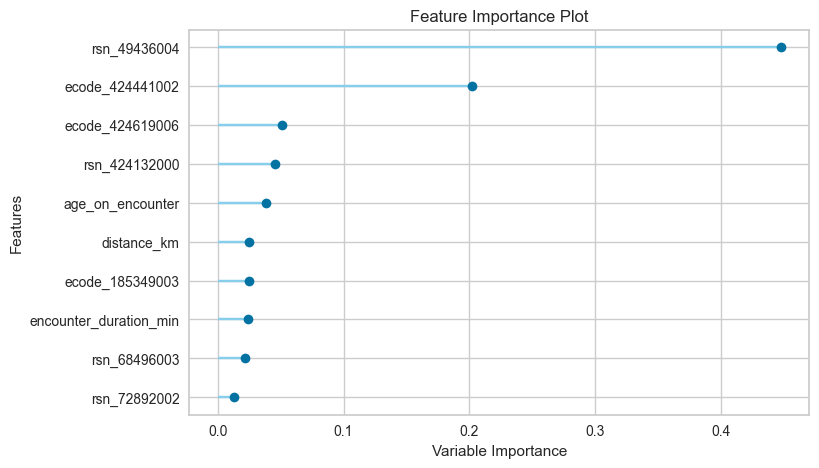

In [122]:
reg = setup(main[main.total_claim_cost<75000.][main_cols_removed], 
            target='total_claim_cost', 
            session_id=789, 
            train_size=0.8,
            normalize=False, 
            transformation=False, 
            verbose=True)

rf3 = create_model('rf')
tuned_rf3 = tune_model(rf3, n_iter=10, custom_grid=custom_grid)

plot = plot_model(tuned_rf3, plot = 'error')
plot_model(tuned_rf3, plot = 'residuals')
plot_model(tuned_rf3, plot = 'feature')

#### Removing features that are GDPR sensitive

,Description,Value
0,Session id,456
1,Target,total_claim_cost
2,Target type,Regression
3,Original data shape,"(27883, 154)"
4,Transformed data shape,"(27883, 154)"
5,Transformed train set shape,"(22306, 154)"
6,Transformed test set shape,"(5577, 154)"
7,Numeric features,153
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1349.6655,15859203.6966,3982.3616,0.7765,0.5961,0.5917
1,1352.3566,14746805.8202,3840.1570,0.7877,0.5723,0.5807
2,1173.4723,12767681.3128,3573.1892,0.7780,0.5973,0.6126
3,1105.3353,9728771.0593,3119.0978,0.8362,0.5998,0.5711
4,1208.7324,12105727.3176,3479.3286,0.8085,0.6082,0.6006
5,1300.7315,13644227.1937,3693.8093,0.8001,0.5839,0.6190
6,1148.5006,12740115.8081,3569.3299,0.7838,0.5612,0.5843
7,1304.5323,15942218.9527,3992.7708,0.7889,0.5834,0.5861
8,1070.2980,10213355.1396,3195.8340,0.8240,0.5805,0.4942


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1331.7403,14153737.2736,3762.1453,0.8005,0.7949,0.9307
1,1363.9101,14653445.7253,3827.9819,0.7891,0.6987,0.7246
2,1155.4320,11110262.7839,3333.2061,0.8068,0.7740,0.8818
3,1155.8971,9529050.6374,3086.9160,0.8395,0.7186,0.8007
4,1206.8588,11551448.3381,3398.7422,0.8172,0.7079,0.7701
5,1344.6351,13086883.7999,3617.5798,0.8082,0.7622,0.8263
6,1200.4231,13449362.9570,3667.3373,0.7717,0.6799,0.7769
7,1364.5138,16295332.2240,4036.7477,0.7842,0.7070,0.8146
8,1139.0467,10561190.5048,3249.7985,0.8180,0.7304,0.7788


Fitting 10 folds for each of 10 candidates, totalling 100 fits


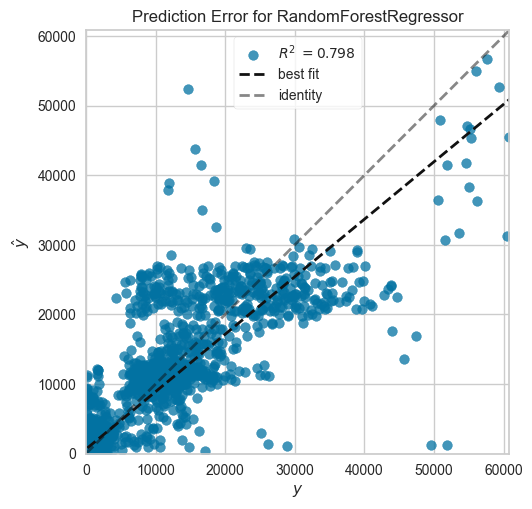

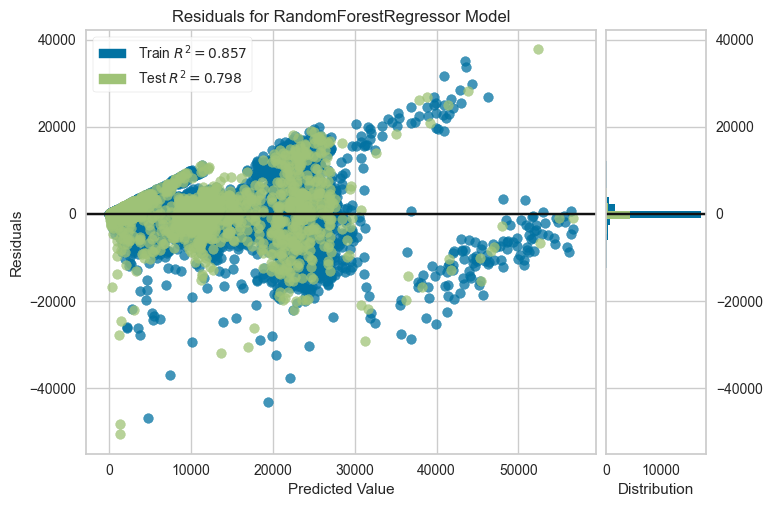

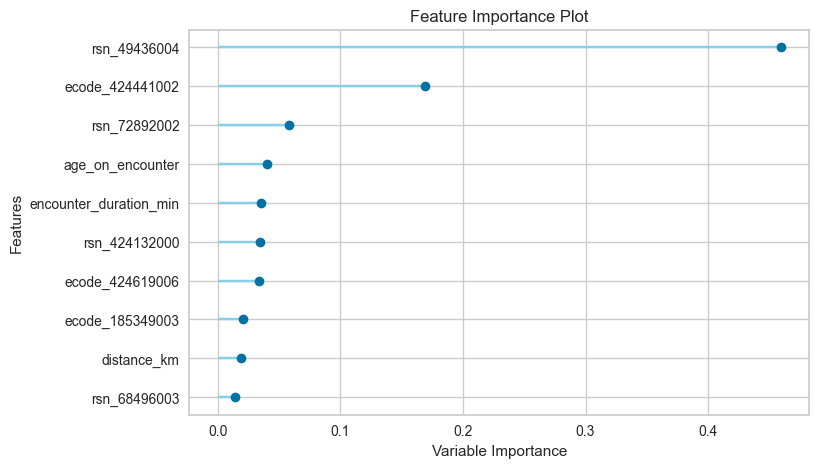

In [121]:
prefixes = ('gender_', 'ethnicity_', 'race_')
main_cols_removed = [item for item in main.columns.values.tolist()[2:] if not item.startswith(prefixes)]
reg = setup(main[main.total_claim_cost<75000.][main_cols_removed], 
            target='total_claim_cost', 
            session_id=456, 
            train_size=0.8,
            normalize=True, 
            transformation=True, 
            verbose=True)

rf2 = create_model('rf')
tuned_rf2 = tune_model(rf2, n_iter=10, custom_grid=custom_grid)

plot = plot_model(tuned_rf2, plot = 'error')
plot_model(tuned_rf2, plot = 'residuals')
plot_model(tuned_rf2, plot = 'feature')

## Feature importances

The top 10 features with the most impact on the model are listed below:
* reason codes: 49436004, 424132000, 68496003, 72892002
* encounter codes: 424441002, 424619006, 185349003, 230690007
* age of the patient during the encounter
* distance of the patient's home address to the hospital in km
* duration of the encounter in minutes

In [210]:
conn = sqlite3.connect('mgh_data.db')
query = """select distinct 
id as encounter_id
, patient as patient_id
, cast(cast(reasoncode as integer) as text) as rsn
, reasondescription
from encounters
where reasoncode is not null

union all

select distinct 
encounter as encounter_id
, patient as patient_id
, cast(cast(reasoncode as integer) as text) as rsn
, reasondescription
from procedures
where reasoncode is not null
"""
reasoncodes = pd.read_sql_query(query, conn).drop_duplicates()
print(reasoncodes.shape)
print(reasoncodes[reasoncodes.rsn.isin(['49436004', '424132000', '68496003', '72892002'])][['rsn', 'reasondescription']].drop_duplicates())
print('\nMOST COMMON REASON CODES/DESCRIPTION IN THE DATA')
reasoncodes.reasondescription.value_counts().head(10)
# conn.close()

(11396, 4)
            rsn                                         reasondescription
3     424132000  Non-small cell carcinoma of lung  TNM stage 1 (disorder)
8      72892002                                          Normal pregnancy
2095   68496003                                            Polyp of colon
8354   49436004                                       Atrial Fibrillation

MOST COMMON REASON CODES/DESCRIPTION IN THE DATA


Atrial Fibrillation                                         1744
Chronic congestive heart failure (disorder)                 1738
Hyperlipidemia                                              1565
Normal pregnancy                                            1380
Malignant neoplasm of breast (disorder)                      907
Viral sinusitis (disorder)                                   732
Acute viral pharyngitis (disorder)                           400
Acute bronchitis (disorder)                                  352
Non-small cell carcinoma of lung  TNM stage 1 (disorder)     343
Alzheimer's disease (disorder)                               191
Name: reasondescription, dtype: int64

This shows that the top reason codes to influence the prediction of the total claim cost are also some of the most commonly found on the data set. This is expected since the model can better generalize pattern with more data in each of the categorical features of the reason codes (diagnosis codes).

The same observation can be made on the encounter codes shown below.

In [211]:
query = """select distinct 
id as encounter_id
, patient as patient_id
, cast(cast(code as integer) as text) as code
, description
from encounters
"""
encountercodes = pd.read_sql_query(query, conn).drop_duplicates()
print(encountercodes.shape)
print(encountercodes[encountercodes.code.isin(['424441002', '424619006', '185349003', '230690007'])][['code', 'description']].drop_duplicates())
print('\nMOST COMMON ENCOUNTER CODES/DESCRIPTION IN THE DATA')
encountercodes.description.value_counts().head(20)
# conn.close()

(27891, 4)
          code                         description
2    185349003  Encounter for check up (procedure)
19   185349003            Encounter for 'check-up'
31   424619006                      Prenatal visit
360  424441002              Prenatal initial visit
710  230690007                              Stroke

MOST COMMON ENCOUNTER CODES/DESCRIPTION IN THE DATA


Encounter for problem (procedure)                                   4308
Urgent care clinic (procedure)                                      3633
Encounter for check up (procedure)                                  2950
General examination of patient (procedure)                          1880
Encounter for symptom                                               1824
Follow-up encounter                                                 1565
Telemedicine consultation with patient                              1548
Emergency Encounter                                                 1475
Patient encounter procedure (procedure)                             1059
Prenatal visit                                                      1026
Administration of vaccine to produce active immunity (procedure)    1003
Encounter for problem                                                959
Patient encounter procedure                                          681
Encounter for 'check-up'                           

#### Analyzing the distributions of the other three features (age_on_encounter, encounter_duration_min, distance_km)

The distributions of these three features across the spread of the target variable (total claim cost) are apparent, covering a good amount of observed space across the range. However, all three do not display any linear trends on the scatter plot against the total claim cost but show clusters. Both the nonlinearity and the non-normally distributed characteristics of these numeric features in the data set, agrees with the choice of model as discussed above.

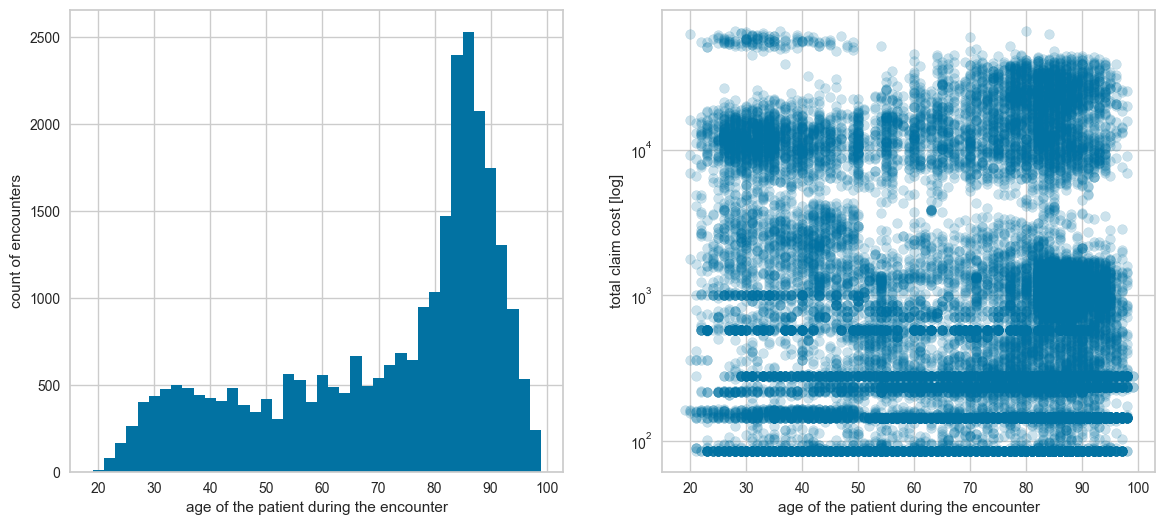

In [187]:
plt.figure(figsize=(14,6))
plt.subplot(121)
encounters[encounters.total_claim_cost<75000.].age_on_encounter.hist(bins=40)
plt.xlabel('age of the patient during the encounter'); plt.ylabel('count of encounters');
plt.subplot(122)
plt.scatter(encounters[encounters.total_claim_cost<75000.].age_on_encounter, encounters[encounters.total_claim_cost<75000.].total_claim_cost, alpha=0.2)
plt.xlabel('age of the patient during the encounter'); plt.ylabel('total claim cost [log]'); plt.yscale('log');

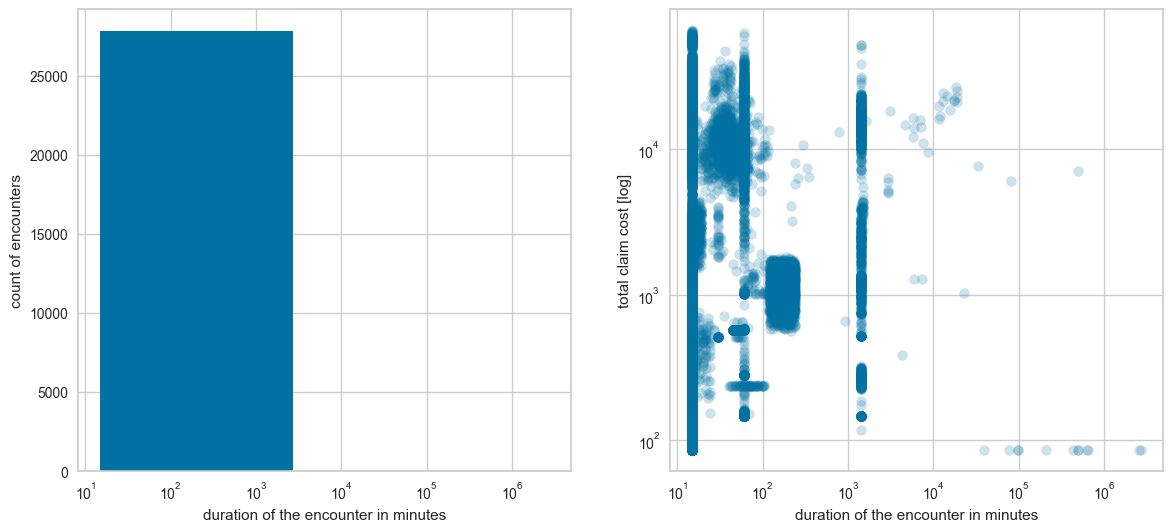

In [205]:
plt.figure(figsize=(14,6))
plt.subplot(121)
encounters[(encounters.total_claim_cost<75000.)].encounter_duration_min.plot.hist(bins=1000)
plt.xlabel('duration of the encounter in minutes'); plt.ylabel('count of encounters'); plt.xscale('log');
plt.subplot(122)
plt.scatter(encounters[encounters.total_claim_cost<75000.].encounter_duration_min, encounters[encounters.total_claim_cost<75000.].total_claim_cost, alpha=0.2)
plt.xlabel('duration of the encounter in minutes'); plt.ylabel('total claim cost [log]'); plt.xscale('log'); plt.yscale('log'); 

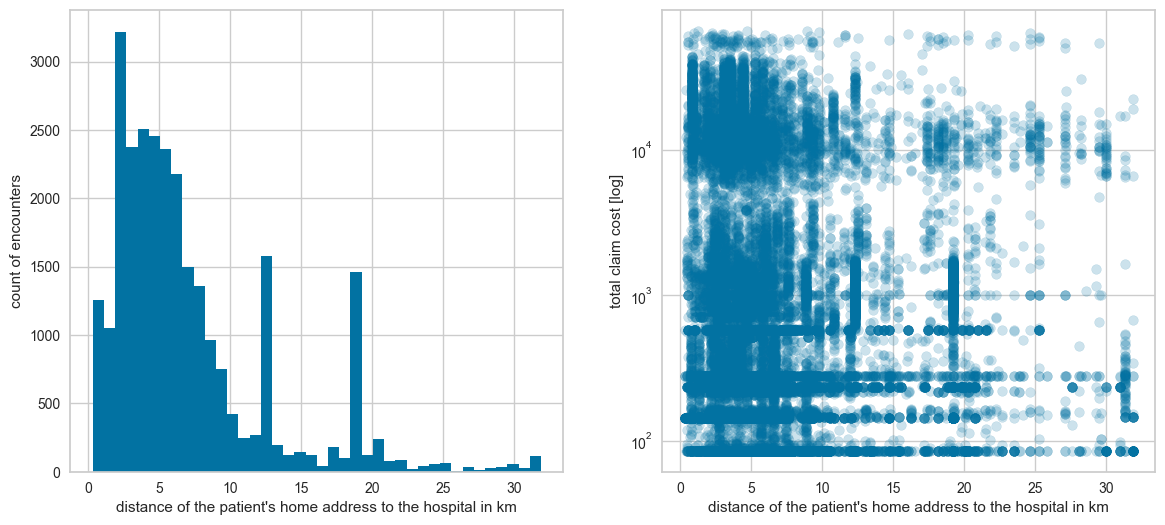

In [207]:
plt.figure(figsize=(14,6))
plt.subplot(121)
encounters[encounters.total_claim_cost<75000.].distance_km.hist(bins=40)
plt.xlabel("distance of the patient's home address to the hospital in km"); plt.ylabel('count of encounters');
plt.subplot(122)
plt.scatter(encounters[encounters.total_claim_cost<75000.].distance_km, encounters[encounters.total_claim_cost<75000.].total_claim_cost, alpha=0.2)
plt.xlabel("distance of the patient's home address to the hospital in km"); plt.ylabel('total claim cost [log]'); plt.yscale('log');

### Potential business use cases:
* Predicted total claim costs can be used as a quote at triage.
* Predictions can be sent ahead to insurance provider for pre-authorization or a more informal check if the patient still has credits.
* Total claim costs that are not comparable to predicted total claim cost can be audited by the insurance provider for potential cases of overutilization or unnecessary care leading to overbilling.

### Further recommendations

* The model might be improved if the procedure data was included in the features, however, more data should be added to keep the feature-to-sample ratio with the additional 180+ features from the procedure codes.
* A more exhaustive hyperparameter tuning can be performed to see if the model's accuracy can be improved.
* Since the feature importances from the model show that the top features are from the reason codes/diagnosis codes, encounter codes, proximity of the patient to the hospital, duration of the encounter, and age of the the patient, the GDPR sensitive data such as the marital status, gender, race, and ethniity can be removed from the feature set to eliminate potential conflict in legal compliance and properly observe ethical and fair practices. If the data set was large enough, it might be beneficial to create separate models for different demographic groups to avoid bias, provided this is done in an ethical and legal manner. Data imputation on these information should not be done as GDPR requires that these are collected as accurately as possible.

### Challenges encountered

* Main challenge encountered was my current limitation in computing resources so the features were kept to the encounter and patient data and the procedure data was excluded. The first two use cases mentioned above are assumed to keep the input date/features to the encounter and patient data for practicality purposes due to this constraint.

In [ ]:
numpy
pandas
matplotlib
pycaret
sklearn
sqlite3